In [1]:
import numpy as np
from Metrics import *
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from time import time
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.utils import to_scipy_sparse_matrix

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def save(data_tuple, name, output_folder):
    with open(f'{output_folder}/{name}.npy', 'wb') as f:
        pickle.dump(data_tuple, f)

import seaborn as sns

cuda


In [7]:
data = np.load('data/primed_MPC_0/data.npy', allow_pickle=True)


for i in range(len(data[0])):
    print(data[0][0] == data[0][i])

[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True

In [2]:
def make_iREC_evolution(time_arr, lambdas, dt, vesicle_alpha, tube_alpha, device='cpu'):

    #number of timesteps for each phase
    i_pref_time     = int(time_arr[0] / dt)
    pref_time       = int(time_arr[1] / dt)
    i_ves_time      = int(time_arr[2] / dt)
    ves_time        = int(time_arr[3] /dt)
    i_tube_time     = int(time_arr[4] /dt)
    tot_time        = int((np.array(time_arr) / 0.2).sum())

    non_polar_ipref = torch.linspace(lambdas[0][0], 1, i_pref_time, device=device)
    non_polar_pref  = torch.ones(pref_time, device=device)
    non_polar_ives= torch.linspace(1,0,i_ves_time, device=device)
    non_polar_rest  = torch.zeros(ves_time + i_tube_time, device=device)
    non_polar_part  = torch.cat((non_polar_ipref, non_polar_pref, non_polar_ives, non_polar_rest), axis=0)
    non_polar_part = non_polar_part.to(device)

    polar_end_vals  = lambdas[4][1:]
    polar_ipref     = torch.zeros((i_pref_time + pref_time,3), device=device)
    polar_ives_part1= torch.linspace(0,1, i_ves_time, device=device)
    polar_ives      = torch.zeros((i_ves_time, 3), device=device)
    polar_ives[:,0] = polar_ives_part1
    polar_ves       = torch.zeros((ves_time, 3), device=device)
    polar_ves[:,0]  = torch.ones(ves_time, device=device)
    polar_itube     = torch.linspace(0,1, i_tube_time, device=device)
    polar_itube     = polar_end_vals[None:,] * polar_itube[:,None]
    polar_itube[:,0]= torch.linspace(1.0,polar_end_vals[0], i_tube_time, device=device)
    polar_part      = torch.cat((polar_ipref, polar_ives, polar_ves, polar_itube) , axis=0)
    polar_part = polar_part.to(device)

    total = torch.cat((non_polar_part[:,None],polar_part), axis=1)

    alpha_pref_ipref= torch.zeros(i_pref_time + pref_time, device=device)
    alpha_ives      = torch.ones(i_ves_time, device=device) * vesicle_alpha
    alpha_ves       = torch.ones(ves_time, device=device) * vesicle_alpha
    alpha_itube     = torch.linspace(vesicle_alpha, tube_alpha, i_tube_time, device=device)
    alpha_total     = torch.cat((alpha_pref_ipref, alpha_ives, alpha_ves, alpha_itube))
    
    return total, alpha_total, tot_time, torch.tensor([i_pref_time, pref_time, i_ves_time, ves_time, i_tube_time], device=device, dtype=torch.int)


In [8]:
time_arr = torch.tensor([500, 500, 1000, 1000, 500])
lambda_arr = torch.tensor([ [0.3, 0, 0, 0],
                            [0, 0.5, 0.48, 0.02],
                            [0.3, 0, 0, 0],
                            [0, 0.5, 0.42, 0.08],
                            [0, 0.5, 0.42, 0.08]])
dt = 0.2
vesicle_alpha = 0.3
tube_alpha    = 0.5

total_evo, total_alpha_evo, _, _ = make_iREC_evolution(time_arr, lambda_arr, dt, vesicle_alpha, tube_alpha)

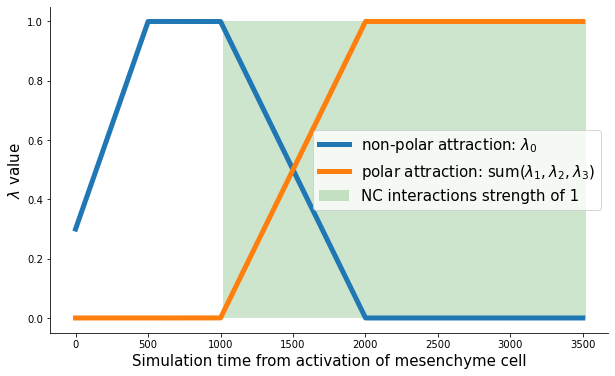

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(total_evo.shape[0]) * dt, total_evo[:,0], label='non-polar attraction: $\lambda_0$', linewidth=5)
ax.plot(np.arange(total_evo.shape[0]) * dt, total_evo[:,1:].sum(axis=1), label='polar attraction: sum($\lambda_1, \lambda_2, \lambda_3$)', linewidth=5)
ax.set_xlabel('Simulation time from activation of mesenchyme cell', fontsize=15)
ax.set_ylabel('$\lambda$ value', fontsize=15)
ax.axhspan(0, 1, 0.31, 0.96, facecolor='green', alpha=0.2, label='NC interactions strength of 1')
ax.legend(fontsize=15)
sns.despine()
plt.show()

In [22]:
total_evo[0]

tensor([0.3000, 0.0000, 0.0000, 0.0000])

In [37]:
mat = np.array([[1,2,3],[4,5,6],[7,8,9]])

vecs = np.arange(30).reshape(10,3)

new_mat = mat[None,:,:].repeat(len(vecs),axis=0)

(new_mat @ vecs[:,:,None]).squeeze()

array([[  8,  17,  26],
       [ 26,  62,  98],
       [ 44, 107, 170],
       [ 62, 152, 242],
       [ 80, 197, 314],
       [ 98, 242, 386],
       [116, 287, 458],
       [134, 332, 530],
       [152, 377, 602],
       [170, 422, 674]])

In [15]:
tens = torch.arange(1,10) * 1000

torch.min(tens).item()

1000

In [6]:
x_min = 1
x_max = 11

np.linspace(x_min, x_max, 5)


array([ 1. ,  3.5,  6. ,  8.5, 11. ])

In [53]:
tens1 = torch.tensor([[1,2,3],[4,5,6],[1,0,1]])
tens2 = torch.tensor([1,2,3])[None].expand(*tens1.shape)
torch.cross(tens1, tens2, dim=1)

tensor([[ 0,  0,  0],
        [ 3, -6,  3],
        [-2, -2,  2]])

In [10]:
def make_random_sphere(N, non_polar_frac , radius=35):
    x = np.random.randn(N, 3)
    r = radius * np.random.rand(N)**(1/3.)
    x /= np.sqrt(np.sum(x**2, axis=1))[:, None]
    x *= r[:, None]

    p = np.random.randn(N, 3)
    p /= np.sqrt(np.sum(p**2, axis=1))[:,None]
    q = np.random.randn(N, 3)
    q /= np.sqrt(np.sum(p**2, axis=1))[:,None]

    mask = np.random.choice([0,1], p=[non_polar_frac, 1-non_polar_frac], size=N)        #Mask detailing which particles are non polar
    p[mask == 0] = np.array([0,0,0])                                                    #Setting the polarities of the non-polarized particles to 0
    q[mask == 0] = np.array([0,0,0])

    sphere_data = (mask, x, p, q)
    return sphere_data

In [42]:
def make_2_spheres(N, x_trans=30, radius=1, include_non_polar=False):

    p_mask1, x1, p1, q1 = make_random_sphere(N//2, 0, radius=radius)
    x2 = x1 + np.array([x_trans, 0,  0])

    x       = np.concatenate((x1, x2), axis=0)
    p_mask  = p_mask1.repeat(2, axis=0) 
    p       = p1.repeat(2, axis=0) 
    q       = q1.repeat(2, axis=0) 
    
    if include_non_polar:
        p_mask_np, x_np, p_np, q_np = make_random_sphere(N*5, 1, radius=x_trans*0.8)
        x_np = x_np + np.array([x_trans/2, 0, 0])
        
        p_mask = np.concatenate((p_mask, p_mask_np), axis=0)
        x = np.concatenate((x, x_np), axis=0)
        p = np.concatenate((p, p_np), axis=0)
        q = np.concatenate((q, q_np), axis=0)


    data = (p_mask, x, p, q)

    return data

In [43]:
data = make_2_spheres(200, include_non_polar=True)

save(data, 'two_sphere_test1', 'testing_two_spheres')

In [5]:
conc_lst = np.linspace(0.5, 0.99, 20)
conc = conc_lst[-1]
folder = f"data/vitro_gradves_grid/conc_{conc:.2f}/data.npy" 
data = np.load(folder, allow_pickle=True)
p_mask_lst, x_lst, _, _ = data

In [6]:
for i in range(len(p_mask_lst)):
    print(np.sum(p_mask_lst[i] ==0))

3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3968
3945
3945
3931
1
1
1
1
1
1
1
1
1
1
1
1


In [47]:
folder = "data/percolation_plot/conc_0.8/data.npy"
data = np.load(folder, allow_pickle=True)

timestep = 25
p_mask  = data[0][timestep]
x       = data[1][timestep]
p_mask = torch.tensor(p_mask, device='cuda')
z_mask, adj_arr = get_adj_lst(x, p_mask)

def get_edge_lst_cuda(adj_arr, z_mask, p_mask):
    adj_arr[z_mask == 0] = -1
    polar_idx = torch.argwhere(p_mask == 1).squeeze()
    non_polar_mask = torch.any(adj_arr[:,:,None] == polar_idx, dim=2)
    double_mask = non_polar_mask * z_mask

    masked_adj_arr = adj_arr * double_mask
    edge_lst = torch.cat((adj_arr[:,0][:,None].expand((adj_arr.shape[0], adj_arr.shape[1])).reshape(-1,1) , masked_adj_arr.reshape(-1,1)), dim=1) 
    edge_lst = edge_lst[edge_lst[:,1] != 0]

    return edge_lst
    
    

C:\Users\s_ute\AppData\Local\Temp\ipykernel_20960\3557058320.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_mask = torch.tensor(p_mask, dtype=torch.int, device=device)


In [60]:
# Testing cpu vs gpu
cpu_lst = []

for i in range(10):
    t = time()
    # CPU
    p_mask_cpu  = p_mask.detach().cpu().numpy()
    z_mask_cpu  = z_mask.detach().cpu().numpy()
    adj_arr_cpu = adj_arr.detach().cpu().numpy()
    edge_lst    = fix_polar_adj_arr(adj_arr=adj_arr_cpu, p_mask=p_mask_cpu,z_mask=z_mask_cpu)
    edge_lst    = get_edge_lst(adj_arr_cpu)
    graph       = make_graph(edge_lst)

    cpu_lst.append(time() - t)

gpu_lst = []
for i in range(10):
    t = time()
    edge_lst    = get_edge_lst_cuda(adj_arr, z_mask=z_mask, p_mask=p_mask)
    graph       = make_graph(edge_lst.detach().cpu().numpy())

    gpu_lst.append(time() - t)

1.1415693759918213

In [59]:
edge_lst    = get_edge_lst_cuda(adj_arr, z_mask=z_mask, p_mask=p_mask)
gpu_graph       = make_graph(edge_lst.detach().cpu().numpy())

p_mask_cpu      = p_mask.detach().cpu().numpy()
z_mask_cpu      = z_mask.detach().cpu().numpy()
adj_arr_cpu     = adj_arr.detach().cpu().numpy()
adj_arr_cpu     = fix_polar_adj_arr(adj_arr=adj_arr_cpu, p_mask=p_mask_cpu,z_mask=z_mask_cpu)
edge_lst        = get_edge_lst(adj_arr_cpu)
cpu_graph       = make_graph(edge_lst)


In [53]:
cpu_lst = []
for  comp in nx.connected_components(cpu_graph):
    cpu_lst.append(len(comp))

gpu_lst = []
for  comp in nx.connected_components(gpu_graph):
    gpu_lst.append(len(comp))


In [54]:
np.array(cpu_lst) == np.array(gpu_lst)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [41]:
len(cpu_graph.nodes)
len(gpu_graph.nodes)

14761

In [160]:
lst = np.array(lst)

np.sum(lst == -1)

0

In [150]:
(sum(cpu_lst) - sum(gpu_lst)) / sum(cpu_lst)

0.3657518776798087

In [98]:
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops

edge_lst = get_edge_lst_cuda(adj_arr, z_mask, p_mask)

edge_lst_no_self_loops, _ = remove_self_loops(edge_lst.T)

graph = Data(edge_index=edge_lst_no_self_loops, num_nodes = len(adj_arr))



In [114]:
def make_graph(edge_lst):
    G = nx.from_edgelist(edge_lst)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

make_graph(edge_lst)

In [132]:
    G = make_graph(edge_lst.detach().cpu().numpy())
    G.remove_edges_from(nx.selfloop_edges(G))


In [117]:
edge_lst

tensor([[    1,     1],
        [    1,  4712],
        [    1, 10398],
        ...,
        [17975, 17975],
        [17975, 13833],
        [17975,  8821]], device='cuda:0')

In [9]:
folder = "data/percolation_plot/conc_0.8/data.npy"
data = np.load(folder, allow_pickle=True)

timestep = -1
p_mask  = data[0][timestep]
x       = data[1][timestep]
p_mask = p_mask
z_mask, adj_arr = get_adj_lst(x, p_mask)

p_mask = p_mask
z_mask = z_mask.detach().cpu().numpy()
adj_arr = adj_arr.detach().cpu().numpy()

adj_lst     = fix_polar_adj_arr(adj_arr, p_mask, z_mask )
edge_lst_cpu    = make_edge_lst(adj_lst)
graph       = make_graph(edge_lst)
egde_lst_cpu = torch.tensor(edge_lst_cpu, device='cuda')


In [29]:
def torch_intersect(a, b):
 intersection = a[(a.view(1, -1) == b.view(-1, 1)).any(dim=0)]
 return intersection

def torch_intersect2(a, b):
    # a = a.unique()
    # b = b.unique()
    a_cat_b, counts = torch.cat([a, b]).unique(return_counts=True)
    intersection = a_cat_b[torch.where(counts.gt(1))]
    return intersection

def fix_polar_adj_arr(adj_arr, p_mask, z_mask):
    adj_arr[z_mask == 0] = -1
    polar_idx = np.argwhere(p_mask == 1).squeeze()
    adj_lst = [] 
    for sub_arr in adj_arr:
        polar_neighbors = list(np.intersect1d(sub_arr,polar_idx))
        adj_lst.append(polar_neighbors)
    return adj_lst

def fix_polar_arr_2(adj_arr, p_mask, z_mask):
    adj_arr[z_mask == 0] = -1
    polar_idx = np.argwhere(p_mask == 1).squeeze()
    

def fix_polar_adj_arr_cuda(adj_arr, p_mask, z_mask):
    adj_arr[z_mask == 0] = -1
    polar_idx = torch.argwhere(p_mask == 1).squeeze()
    adj_lst = [] 
    for sub_arr in adj_arr:
        polar_neighbors = list(torch_intersect2(sub_arr,polar_idx))
        adj_lst.append(polar_neighbors)
    return adj_lst

def get_edge_lst(adj_arr):
    edge_lst = []
    for sub_arr in adj_arr:
        for entry in sub_arr:
            edge_lst.append((sub_arr[0],entry))
    return edge_lst

def make_graph(edge_lst):
    G = nx.from_edgelist(edge_lst)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

def get_adj_lst(x, p_mask=None, seethru=0, k=50):
    d, idx = find_potential_neighbours(x, k=k)
    idx = torch.tensor(idx, dtype=torch.long, device=device)
    d = torch.tensor(d, dtype=torch.float, device=device)
    x = torch.tensor(x, dtype=torch.float, device=device)
    p_mask = torch.tensor(p_mask, dtype=torch.int, device=device)

    full_n_list = x[idx]
    dx = x[:, None, :] - full_n_list
    z_mask = find_true_neighbours(d, dx, seethru=seethru)

    sort_idx = torch.argsort(z_mask.int(), dim=1, descending=True)
    z_mask = torch.gather(z_mask, 1, sort_idx)
    idx = torch.gather(idx, 1, sort_idx)
    m = torch.max(torch.sum(z_mask, dim=1)) + 1
    z_mask = z_mask[:, :m]
    idx = idx[:, :m]

    polar_idx       = idx[p_mask == 1]
    return z_mask[p_mask == 1], polar_idx #.detach().to("cpu").numpy(),


# min_ves_time_bool = tstep > (self.pre_polar_dur + self.warmup_dur + self.min_ves_time)
# if self.update_neighbors_bool(tstep, division) and (self.vesicle_formation == True and min_ves_time_bool):

#     # Append the name of the nodes themselves
#     extended_idx    = torch.cat( (torch.arange(len(idx), device=self.device)[:,None] , idx ), dim=1) #CANNOT BE CHANGED
#     extended_z_mask = torch.cat( (torch.ones(len(idx), device=self.device)[:,None] , z_mask ), dim=1) #CANNOT BE CHANGED

#     # Transition to cpu
#     polar_idx   = extended_idx[p_mask != 0].detach().to("cpu").numpy()
#     polar_z_mask= extended_z_mask[p_mask != 0].detach().to("cpu").numpy()
    
    # Find graph structure of polar particles
    temp_p_mask = torch.where(p_mask == 2, 1, p_mask)
    adj_lst     = fix_polar_adj_arr(polar_idx, temp_p_mask.detach().to("cpu").numpy(), polar_z_mask )
    edge_lst    = make_edge_lst(adj_lst)
    graph       = make_graph(edge_lst)

    # Find sizes of connected components
    # If connected component size > threshold --> p_mask = 2 --> Tube
    for comp in nx.connected_components(graph):
        if len(comp) > self.crit_ves_size:
            p_mask[list(comp)] = 2
            self.beta[list(comp)] = self.polar_prolif_rate

In [13]:
folder = "data/percolation_plot/conc_0.8/data.npy"
data = np.load(folder, allow_pickle=True)

timestep = 25
p_mask  = data[0][timestep]
x       = data[1][timestep]

In [18]:
z_mask, polar_adj_arr = adj_lst(x, p_mask, seethru=0)
n_polar_particles = polar_adj_arr.shape[0]
polar_adj_arr = fix_polar_adj_arr(polar_adj_arr, p_mask, z_mask)
edge_lst = make_edge_lst(polar_adj_arr)
graph = make_graph(edge_lst)

In [ ]:
import numpy as np
import scipy.sparse as sp

assert data.edge_index is not None

adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes)

num_components, component = sp.csgraph.connected_components(
    adj, connection=self.connection)

In [ ]:
def get_components(self, data: Data) -> Data:
    import numpy as np
    import scipy.sparse as sp

    assert data.edge_index is not None

    adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes)

    num_components, component = sp.csgraph.connected_components(
        adj, connection=self.connection)

_, count = np.unique(component, return_counts=True)
subset_np = np.in1d(component, count.argsort()[-self.num_components:])
subset = torch.from_numpy(subset_np)
subset = subset.to(data.edge_index.device, torch.bool)

return data.subgraph(subset)

In [32]:
arr = np.arange(8_000)

for comp in nx.connected_components(graph):
    if len(comp) > 10:
        print(comp)
        print(arr[list(comp)])

{1, 4217, 4486, 2470, 2061, 1903, 880, 4209, 1748, 600, 4313, 4346, 2044}
[   1 4217 4486 2470 2061 1903  880 4209 1748  600 4313 4346 2044]
{4097, 4098, 4099, 4100, 4102, 9, 2058, 4107, 4109, 4110, 4111, 4113, 2065, 2066, 2070, 4118, 4119, 2073, 26, 4123, 4124, 4125, 4126, 4128, 2084, 4139, 4140, 4141, 46, 45, 4144, 4145, 2098, 2094, 2099, 60, 4169, 4173, 4174, 4176, 81, 4182, 86, 2138, 4189, 4190, 2141, 4191, 4194, 4196, 4201, 4202, 4203, 4204, 109, 4206, 2160, 4212, 117, 4214, 4215, 2171, 2172, 2173, 4222, 2175, 4223, 4225, 4224, 129, 4228, 4220, 4231, 2184, 4233, 4232, 4236, 4243, 4244, 4247, 4251, 4254, 4255, 2207, 4258, 4260, 4263, 2217, 4269, 4270, 4273, 2227, 180, 4277, 4278, 4276, 2232, 4282, 4283, 4284, 4285, 4290, 4291, 2243, 4297, 4299, 4303, 4307, 212, 215, 4311, 218, 4315, 2268, 4317, 2270, 4316, 4321, 4324, 4327, 234, 4332, 4333, 243, 4340, 4343, 248, 2297, 4344, 4349, 4352, 4355, 4358, 4361, 4362, 4364, 4365, 4366, 4368, 4369, 274, 4372, 2326, 4374, 4376, 4377, 4378, 43

In [12]:
tens = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
torch.cat((torch.arange(3)[:,None], tens), dim=1)

tensor([[0, 1, 2, 3],
        [1, 4, 5, 6],
        [2, 7, 8, 9]])

In [24]:
data1 = np.load('data/vitro_tests/cell_wall_eq_old/data.npy', allow_pickle=True)
data2 = np.load('data/vitro_tests/cell_wall_eq_change_test/data.npy', allow_pickle=True)
timestep = 50

x1 = data1[1][timestep]
x2 = data2[1][timestep]

array([[-2.239963  , -1.5063416 , -0.87497884],
       [-4.2369947 ,  0.28424537,  0.20803016],
       [-5.074004  ,  0.6107918 , -1.3571935 ],
       [-3.585723  , -0.582757  , -0.9653107 ],
       [ 6.487363  , -1.265897  ,  0.6363412 ],
       [ 0.7575443 , -2.0669246 ,  1.2632843 ],
       [-1.1597525 , -2.594687  ,  1.0051353 ],
       [-0.8308311 ,  2.2119133 , -1.0668141 ],
       [ 1.6305232 ,  2.4604192 , -0.8120954 ],
       [ 0.5845654 , -1.913485  , -0.4769032 ],
       [ 1.8443612 , -2.3085334 ,  1.4297822 ],
       [-0.8554746 ,  1.3700558 , -1.2095658 ],
       [ 0.29733947, -2.2286706 ,  0.46174234],
       [-0.6581056 ,  1.0855105 , -1.822763  ],
       [ 1.6186295 ,  1.2684615 , -1.083739  ],
       [ 1.0508695 ,  2.5293787 , -0.18542713],
       [-1.3530201 , -2.250545  ,  2.7499418 ],
       [ 0.80801475, -1.6986449 ,  1.7643217 ],
       [-2.2436914 ,  0.6608447 , -1.8929358 ],
       [-4.638923  ,  0.73102564, -0.96849287],
       [ 1.1812333 ,  1.8452377 , -0.697

In [6]:
len(([1,2,3],(2,3),4,5,6))

5

In [1]:
sph1_bound_loc  = [0,0,0]
sph1_radius     = 10

sph2_bound_loc  = [9,0,0]
sph2_radius     = 5

bound_str = 0.1

def sphere_bound(x):
    bound1_dists= torch.sqrt(torch.sum((sph1_bound_loc -  x)**2, dim=1))
    bound2_dists= torch.sqrt(torch.sum((sph2_bound_loc -  x)**2, dim=1))
    v_add1      = torch.where(bound1_dists > sph1_radius, 1/2 * bound_str * (bound1_dists - sph1_radius)**2, 0.0)
    v_add2      = torch.where(bound2_dists > sph2_radius, 1/2 * bound_str * (bound2_dists - sph2_radius)**2, 0.0)
    v_add = torch.min(v_add1, v_add2)

    v_add = torch.sum(v_add)

    return v_add

In [24]:
mask = torch.tensor([1,0,1], dtype=torch.bool)

tens1 = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
tens2 = torch.tensor([-1,-1,-1])

torch.where(mask[:,None], tens1, tens2)
torch.any(tens1[None], dim=0)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

In [6]:
mask1 = torch.tensor([1,0,1,1,0,0,0,1], dtype=torch.bool)
mask2 = torch.tensor([0,0,1,1,0,0,0,0], dtype=torch.bool)

mask3 = torch.logical_or(mask1, mask2)
mask1[mask2] = 0


print(mask1)
print(mask3)

tensor([ True, False, False, False, False, False, False,  True])
tensor([ True, False,  True,  True, False, False, False,  True])


In [10]:
tens1 = torch.tensor([1,0,0,0])
tens2 = torch.tensor([0,1,0,0])

torch.where(torch.tensor([1,1,1,0,0,0,1,0], dtype=torch.bool)[:,None], tens1, tens2)

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

In [17]:
tens = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
mask = torch.tensor([[1,0,1],[0,1,0],[1,0,1]], dtype=torch.bool)

mask >0

tensor([[ True, False,  True],
        [False,  True, False],
        [ True, False,  True]])

In [39]:
tens1    = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
# tens2   = torch.tensor([[[1,1,1],[2,2,2],[3,3,3],[4,4,4]],[[1,1,1],[2,2,2],[3,3,3],[4,4,4]],[[1,1,1],[2,2,2],[3,3,3],[4,4,4]]])
tens1[:,:,None].expand(3,3,5)

tensor([[1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3]])

In [88]:
data = np.load('data/testing_comma2/data.npy', allow_pickle=True)
mask = data[0]
x = data[1]

In [83]:
def group_mean(myArray, N=2):
    result = np.cumsum(myArray)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

In [84]:
def get_activation_times(mask, N_mean = None):
    mask = np.vstack(mask)
    activation_arr = np.sum((mask[:-1] - mask[1:]) == -3, axis=1)
    if N_mean:
        activation_arr = group_mean(activation_arr, N_mean)
    return activation_arr

In [85]:
def plot_activation_times(activations, dt, N_mean=None, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    activations = np.roll(np.append(activations , activations[0]), 1)
    time = np.arange(0,len(activations)) * dt
    if N_mean:
        time *= N_mean
    ax.step(time, activations)
    return ax

<Axes: >

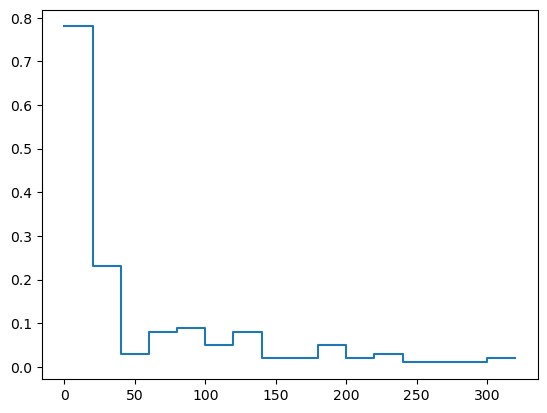

In [87]:
act = get_activation_times(mask, N_mean=100)
plot_activation_times(act, 0.2, N_mean=100)

In [125]:
source_pos = np.array([0,0,5])

def endpos_vs_activation(mask, x, source, dt):
    mask = np.vstack(mask)
    activation_arr = (mask[:-1] - mask[1:]) == -3
    x_end = x[-1]

    ind = []
    times = []
    for i in range(activation_arr.shape[0]):
        indices = np.argwhere(activation_arr[i])
        if np.any(indices):
            ind.append(indices)
            times += [i*dt]*len(indices)
    ind = np.concatenate(ind).squeeze()
    end_pos = x_end[ind]
    dist_from_source =  np.sum(np.abs(source - end_pos), axis=1)
    times = np.array(times)
    return dist_from_source, times

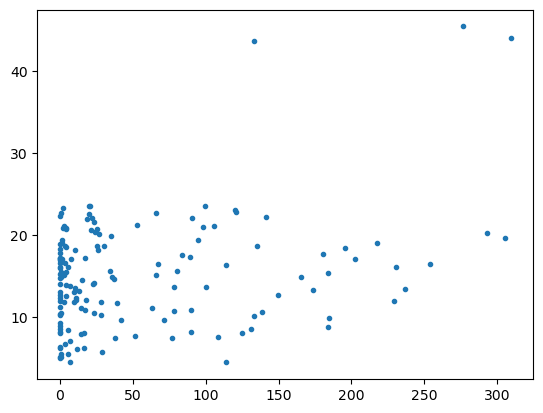

In [129]:
dists, times = endpos_vs_activation(mask, x, source_pos, dt=0.2)
# print(dists)
plt.plot(times, dists,'.')

In [41]:
test_arr = np.array([1,2,3,4,5,6,7,8,9,10])
groupedAvg(test_arr)

array([1.5, 3.5, 5.5, 7.5, 9.5])

In [65]:
activation_arr = np.sum((mask[:-1] - mask[1:]) == -3, axis=1)
meaned_arr = groupedAvg(activation_arr,N=25)

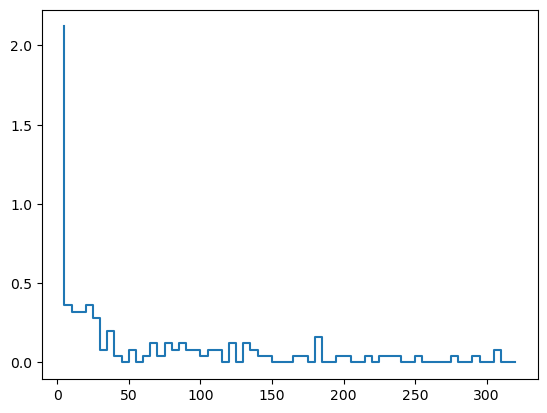

In [67]:
time_arr = np.arange(1,len(meaned_arr)+1) * 0.2 * 25
plt.step(time_arr, meaned_arr)

In [3]:
import numpy as np
import pickle
data = np.load('data/ubud_w_mcap/data.npy', allow_pickle=True)
data = (data[0][-1], data[1][-1], data[2][-1], data[3][-1])

def save(data_tuple, name, output_folder):
    with open(f'{output_folder}/{name}.npy', 'wb') as f:
        pickle.dump(data_tuple, f)

save(data, 'ubud_mcap_final.npy', 'data')


In [9]:
p_mask = torch.tensor([1,1,1,2,2,5,1,2,1,2])
x      = torch.arange(len(p_mask) * 3).reshape(-1,3)

x[torch.logical_or(p_mask == 1, p_mask == 5)]

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [15, 16, 17],
        [18, 19, 20],
        [24, 25, 26]])

In [9]:
p_mask = torch.tensor([1,2,2,3,1,1,2,2,3,3])
idx = torch.tensor([[1,2,3],[2,3,4],[3,4,5],[5,6,7],[1,2,3],[0,9,1],[1,4,5],[0,2,6],[8,9,3],[1,4,8]])

interaction_mask = torch.cat((p_mask[:,None].expand(p_mask.shape[0], idx.shape[1])[:,:,None], p_mask[idx][:,:,None]), dim=2)

In [17]:
p_mask[torch.logical_and(interaction_mask == torch.tensor([1,1]),axis=2)]

TypeError: logical_and() missing 1 required positional arguments: "other"

In [82]:
tens = torch.tensor([1,2,3,4,5,6,1,2,3,4,5,6])

tens[tens < 3][tens[tens<3] == 1] = 0

tens[tens<3][tens[tens<3] == 1] = 0
tens[torch.logical_and(tens < 3, tens == 1)] = 0
tens

tensor([0, 2, 3, 4, 5, 6, 0, 2, 3, 4, 5, 6])

In [30]:
tens = torch.tensor([[1,2,4,5,4],[1,4,5,2,1],[1,2,5,2,5],[3,1,3,0,4]])

torch.logical_or(tens == 1, tens == 5)

tensor([[ True, False, False,  True, False],
        [ True, False,  True, False,  True],
        [ True, False,  True, False,  True],
        [False,  True, False, False, False]])

In [63]:
tens = torch.tensor([[1,2,3],[0,0,6],[0,0,0],[0,0,0]])

tens[torch.sum(tens, dim=1) == 0] = torch.tensor([1,1,2])

tens


tensor([[1, 2, 3],
        [0, 0, 6],
        [1, 1, 2],
        [1, 1, 2]])

In [24]:
import os

folder = "data/testing_cylinder_cross_1/data.npy"

data = np.load(folder, allow_pickle=True)

mask, x, p, q = data

mask    = mask[-1]
x       = x[-1]
p       = p[-1]
q       = q[-1]

x[:,2] -= 0.45 * 75
x[:,1] += 0.35 * 75

# mask.shape
# os.mkdir('data/u_bud')

# np.save('data/u_bud/data.npy', ([mask], [x], [p], [q]), allow_pickle=True)

with open(f'data/u_bud/data.npy', 'wb') as f:
    pickle.dump(([mask], [x], [p], [q]), f)

In [26]:
folder = "data/u_bud/data.npy"
data = np.load('data/u_bud/data.npy', allow_pickle=True)

data[1]

[array([[ -8.105346 ,  35.91753  , -16.913588 ],
        [ 14.031862 ,  20.65406  , -16.527334 ],
        [ -2.739363 ,  15.490184 , -45.925858 ],
        ...,
        [ -4.378603 , -21.04462  ,  24.265991 ],
        [ -4.4308767, -15.0057335,  36.39456  ],
        [  0.6683398, -23.356968 ,  28.507439 ]], dtype=float32)]

In [20]:
index = 0

folder = 'percolation_data/conc0.8_0/data.npy'
data = np.load(folder, allow_pickle=True)
p_mask1 = data[0][index]
x1      = data[1][index]
p1      = data[2][index]
q1      = data[3][index]

folder = 'percolation_data/conc0.8_2/data.npy'
data = np.load(folder, allow_pickle=True)
p_mask2 = data[0][index]
x2      = data[1][index]
p2      = data[2][index]
q2      = data[3][index]

In [21]:
print(x1[0])
print(x2[0])

[-17.86273332 -25.70775741 -11.36804398]
[  2.36260214 -20.90315546  -3.98032369]


In [ ]:
folder = 'data/size10000_conc0.8/data.npy'
data = np.load(folder, allow_pickle=True)
p_mask = data[0][-1]
x      = data[1][-1]
p      = data[2][-1]
q      = data[-1][-1]

In [9]:
p_mask = data[0][-1]
x      = data[1][-1]
p      = data[2][-1]
q      = data[3][-1]

In [46]:
def get_percolation(x, p_mask, seethru=0):
    z_mask, polar_adj_arr = adj_lst(x, p_mask, seethru=seethru)
    n_polar_particles = polar_adj_arr.shape[0]
    polar_adj_arr = fix_polar_adj_arr(polar_adj_arr, p_mask, z_mask)
    edge_lst = make_edge_lst(polar_adj_arr)
    graph = nx.from_edgelist(edge_lst)
    max_cluster_size = len(max(nx.connected_components(graph), key=len))
    print(max_cluster_size)
    print(n_polar_particles)
    perc_prob = max_cluster_size / n_polar_particles
    return perc_prob

In [6]:
seethru = 0
z_mask, polar_adj_arr = adj_lst(x, p_mask, seethru=seethru)
n_polar_particles = polar_adj_arr.shape[0]


polar_adj_arr = fix_polar_adj_arr(polar_adj_arr, p_mask, z_mask)
# edge_lst = make_edge_lst(polar_adj_arr)
# graph = nx.from_edgelist(edge_lst)
# max_cluster_size = len(max(nx.connected_components(graph), key=len))
# print(max_cluster_size)
# print(n_polar_particles)
# perc_prob = max_cluster_size / n_polar_particles

In [10]:
get_percolation(x, p_mask)

0.9956631307507472

In [13]:
def above_threshold(x, p_mask, max_fraction=0.8 , radius=None, k=100):
    if not radius:
        z_mask, idx = adj_lst(x, p_mask, k=k)
        idx = fix_polar_adj_arr(idx, p_mask, z_mask)
        len_lst = [len(x) for x in idx]
        max_neighbors = max(len_lst)
        threshold = max_neighbors * max_fraction
        mask = [neighbors > threshold for neighbors in len_lst]
        return_lst = []
        for i in range(len(mask)):
            if mask[i]:
                return_lst.append(idx[i][0])
        return return_lst

In [19]:
len(above_threshold(x, p_mask, max_fraction=0.5))

848

In [13]:
idx = np.array([1,2,3,4])


array([-2, -3, -4, -5])

In [7]:
folder = 'data/testing_metrics/data.npy'

data = np.load(folder, allow_pickle=True)


In [8]:
p_mask = data[0][-1]
x      = data[1][-1]
q      = data[-1][-1]

In [11]:
branch_particles = get_branching(x, q, p_mask, threshold=0.2)

356

In [ ]:
u_tens = torch.unique(tensor)
u_tens

tensor([    3,     4,     5,  ..., 18944, 19900, 20907])

In [ ]:
p_mask[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
tens = torch.randn((10000,30))
bool_tens = tens < 0
# bool_tens = bool_tens.dtype(torch.int)

idx = torch.argwhere(bool_tens)
idx

tensor([[   0,    0],
        [   0,    1],
        [   0,    3],
        ...,
        [9999,   24],
        [9999,   27],
        [9999,   29]])

In [ ]:
print(len(x[p_mask==1]))

13267


In [ ]:
_, polar_adj_lst = adj_lst(x, p_mask, seethru=0)

In [ ]:
def fix_polar_adj_arr(adj_arr, p_mask):
    polar_idx = np.argwhere(p_mask == 1).squeeze()
    adj_lst = [] 
    for sub_arr in adj_arr:
        polar_neighbors = list(np.intersect1d(sub_arr,polar_idx))
        adj_lst.append(polar_neighbors)
    return adj_lst

def make_edge_lst(adj_arr):
    edge_lst = []
    for sub_arr in adj_arr:
        for entry in sub_arr[1:]:
            edge_lst.append((sub_arr[0],entry))

    return edge_lst

In [ ]:
edge_lst = fix_polar_adj_arr(polar_adj_lst, p_mask)

In [ ]:
edge_lst = make_edge_lst(edge_lst)
graph = nx.from_edgelist(edge_lst)

In [ ]:
cluster_lst = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
sum(cluster_lst)

13266

In [ ]:
sum(cluster_lst)/2

4818.0

In [ ]:
edgelist = [(0, 1),(1,0),(1,0),(0,1),(0,2),(2,0),(1,0),(1,2),(2,1)]  # single edge (0,1)
G = nx.from_edgelist(edgelist)
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[3]

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

653


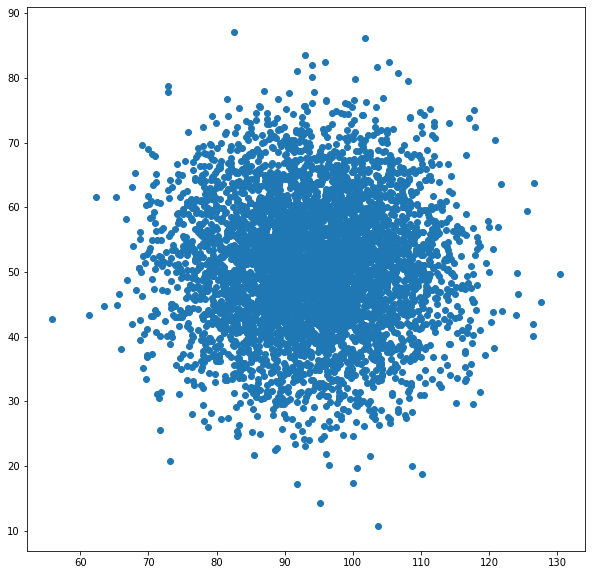

In [57]:
x, _  = make_blobs(5_000, 2, centers=1, cluster_std=1)
x = x * 10
p_mask = np.ones(5_000)

branch_particles = above_threshold(x, p_mask, max_fraction=1, radius=5)
# branch_particles = np.array(branch_particles, dtype=int)

# display_branches(x, p_mask, branch_particles)

plt.figure(figsize=(10,10))
plt.scatter(x[:,0],x[:,1] )
plt.scatter(x[branch_particles][:,0],x[branch_particles][:,1])

In [15]:
branch_particles

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [59]:
tens = torch.tensor([[3,1,2],[4,6,5],[9,8,7]])

torch.sort(tens)

torch.return_types.sort(
values=tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]),
indices=tensor([[1, 2, 0],
        [0, 2, 1],
        [2, 1, 0]]))

In [60]:
def func():
    print('fuck')

In [64]:
func();

SyntaxError: invalid syntax (4273532911.py, line 1)

In [1]:
import numpy as np

In [2]:
def get_centers(x, p, q, p_mask, depression=5  ,num=500):    
    x_polar = x[p_mask == 1].copy()
    p_polar = p[p_mask == 1].copy()
    q_polar = q[p_mask == 1].copy()

    p_polar /= np.sqrt(np.sum(p_polar ** 2, axis=1))[:, None]
    q_polar -= q_polar.dot(p_polar) * p_polar
    q_polar /= np.sqrt(np.sum(q_polar ** 2, axis=0))

    lin_trans = np.zeros((len(x_polar), 3, 3))
    lin_trans[:,:,0] = p_polar
    lin_trans[:,:,1] = q_polar
    lin_trans[:,:,2] = np.cross(p_polar,q_polar)

    x_trans = (np.linalg.inv(lin_trans) @ x_polar[:,:,None]).squeeze()

    subtract_arr =  np.zeros_like(x_trans)
    subtract_arr[:,0] = depression

    trans_centers =  x_trans - subtract_arr
    centers = (lin_trans @ trans_centers[:,:,None]).squeeze()
    sampled_centers = centers[:num]

    return sampled_centers

In [166]:
def get_prolif_positions(x, p, q, p_mask):
    x_polar = x[p_mask == 1].copy()
    p_polar = p[p_mask == 1].copy()
    q_polar = q[p_mask == 1].copy()

    p_polar /= torch.sqrt(np.sum(p_polar ** 2, dim=1))[:, None]
    q_polar -= torch.sum(q_polar * p_polar, dim=1)[:,None] * p_polar
    q_polar /= torch.sqrt(torch.sum(q_polar ** 2, dim=0))

    lin_trans = torch.zeros((len(x_polar), 3, 3))
    lin_trans[:,:,0] = p_polar
    lin_trans[:,:,1] = q_polar
    lin_trans[:,:,2] = torch.cross(p_polar,q_polar)

    new_pos = (torch.linalg.inv(lin_trans) @ x_polar[:,:,None]).squeeze()

    add_arr =  torch.zeros_like(new_pos)
    add_arr[:,1:] = torch.random.normal(size=(new_pos.shape[0],new_pos.shape[1]-1))

    new_pos += add_arr
    new_pos = (lin_trans @ new_pos[:,:,None]).squeeze()

    return new_pos


In [37]:
prolif_scale = 10

x_polar = np.array([[0.,0.,0.]])
p_polar = np.array([[0.,1.,0]])
q_polar = np.array([[1.,0.,0]])

p_polar /= np.sqrt(np.sum(p_polar ** 2, axis=1))[:, None]
q_polar /= np.sqrt(np.sum(q_polar ** 2, axis=1))[:, None]

lin_trans = np.zeros((len(x_polar), 3, 3))
lin_trans[:,:,0] = p_polar
lin_trans[:,:,1] = q_polar
lin_trans[:,:,2] = np.cross(p_polar,q_polar)

x_trans = (lin_trans @ x_polar[:,:,None]).squeeze()
x_trans = x_trans[:,None]

# # subtract_arr =  np.zeros_like(x_trans)
# # subtract_arr[:,1:] = np.random.normal()

x_trans[:,1:] += np.random.normal(scale=prolif_scale, size=(x_trans.shape[0],x_trans.shape[1]))
# new_particle = (np.linalg.inv(lin_trans) @ x_trans[:,:,None]).squeeze()
# new_particle


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

In [158]:
prolif_scale = 1

x_polar = np.array([0.,0.,0.])
p_polar = np.array([1.,1.,0])
q_polar = np.array([0.,1.,0])

p_polar /= np.sqrt(np.sum(p_polar ** 2, axis=0))
q_polar -= q_polar.dot(p_polar) * p_polar
q_polar /= np.sqrt(np.sum(q_polar ** 2, axis=0))

lin_trans = np.zeros((3, 3))
lin_trans[:,0] = p_polar
lin_trans[:,1] = q_polar
lin_trans[:,2] = np.cross(p_polar,q_polar)

x_trans = (np.linalg.inv(lin_trans) @ x_polar).squeeze()

subtract_arr =  np.zeros((100,x_trans.shape[0]))
subtract_arr[:,1:] = np.random.normal(scale=prolif_scale, size=(100, x_trans.shape[0]-1))

new_particles = x_trans + subtract_arr

new_particles = (lin_trans @ new_particles[:,:,None]).squeeze()

In [163]:
(new_particles * np.array([1.,1.,0]))

array([[-0.76051563,  0.76051563,  0.        ],
       [-0.54512378,  0.54512378,  0.        ],
       [ 0.12277653, -0.12277653, -0.        ],
       [-0.10772113,  0.10772113,  0.        ],
       [ 0.92551485, -0.92551485,  0.        ],
       [ 0.7924383 , -0.7924383 ,  0.        ],
       [ 0.90055996, -0.90055996, -0.        ],
       [-0.08185971,  0.08185971, -0.        ],
       [-1.26533185,  1.26533185,  0.        ],
       [ 0.89158316, -0.89158316,  0.        ],
       [ 1.62988819, -1.62988819,  0.        ],
       [ 1.22062807, -1.22062807,  0.        ],
       [-0.03282871,  0.03282871, -0.        ],
       [-0.39658229,  0.39658229,  0.        ],
       [-1.40406763,  1.40406763, -0.        ],
       [-0.63646395,  0.63646395,  0.        ],
       [-0.5870505 ,  0.5870505 , -0.        ],
       [ 0.92022134, -0.92022134,  0.        ],
       [ 0.78738169, -0.78738169, -0.        ],
       [ 1.29644449, -1.29644449,  0.        ],
       [-0.32392508,  0.32392508, -0.   

In [146]:
x_polar = np.array([0.,0.,0.])

lin_trans = np.zeros((3, 3))
lin_trans[:,0] = p_polar
lin_trans[:,1] = q_polar
lin_trans[:,2] = np.cross(p_polar,q_polar)

x_trans = (np.linalg.inv(lin_trans) @ x_polar)
print(x_trans)

x_reversed = lin_trans @ (x_trans + np.array([0,1,1]))
print(x_reversed)

[0. 0. 0.]
[-0.70710678  0.70710678  1.        ]


In [79]:
x_trans[1:] + np.random.normal(scale=prolif_scale, size=(100,x_trans.shape[0]-1))

array([[ -7.04695394,   5.72650817],
       [  4.74403877, -10.09480028],
       [  4.60593477,  -6.88165772],
       [  7.49504916,  -0.06846565],
       [ 10.73492045,   2.94333592],
       [  0.82505616,   2.16562041],
       [  0.31779006,  -7.29044509],
       [ -3.05106859,  -5.34066671],
       [  6.68053251,   8.15165496],
       [-25.33727669,  15.83035473],
       [  0.17028182,  -3.3712562 ],
       [  8.07307821,  -1.85653594],
       [ 25.44276694,  -3.46904819],
       [  0.95288187,   6.8266168 ],
       [ -2.89396302,  21.12911319],
       [ -8.17497458,  11.84159802],
       [ 11.62860488, -10.02541976],
       [ -5.57803518,  -7.93492178],
       [ -7.98409459,  -0.08250032],
       [ -9.20721189,  -9.83474514],
       [-13.8753234 ,   0.5577363 ],
       [ -3.36016771,   8.12382776],
       [ -0.8349459 ,  -5.78806781],
       [  5.93036165, -26.65725548],
       [ -8.47728739, -10.06006323],
       [ -2.49258326,  -3.91244972],
       [ -5.0037387 ,   7.40839502],
 

In [65]:
p_polar = np.array([1.,1.,0])
q_polar = np.array([0.,1.,0])

p_polar /= np.sqrt(np.sum(p_polar ** 2, axis=0))
q_polar /= np.sqrt(np.sum(q_polar ** 2, axis=0))

q_polar -= q_polar.dot(p_polar) * p_polar
q_polar /= np.sqrt(np.sum(q_polar ** 2, axis=0))

In [68]:
p_polar.dot(q_polar)

2.7755575615628914e-16

In [5]:
import torch
torch.manual_seed(42)

for i in range(100):
    print(torch.normal(mean = 0, std = 1, size=(1,2)))

tensor([[0.3367, 0.1288]])
tensor([[0.2345, 0.2303]])
tensor([[-1.1229, -0.1863]])
tensor([[ 2.2082, -0.6380]])
tensor([[0.4617, 0.2674]])
tensor([[0.5349, 0.8094]])
tensor([[ 1.1103, -1.6898]])
tensor([[-0.9890,  0.9580]])
tensor([[1.3221, 0.8172]])
tensor([[-0.7658, -0.7506]])
tensor([[1.3525, 0.6863]])
tensor([[-0.3278,  0.7950]])
tensor([[0.2815, 0.0562]])
tensor([[ 0.5227, -0.2384]])
tensor([[-0.0499,  0.5263]])
tensor([[-0.0085,  0.7291]])
tensor([[0.1331, 0.8640]])
tensor([[-1.0157, -0.8887]])
tensor([[ 0.1498, -0.2089]])
tensor([[-0.3870,  0.9912]])
tensor([[ 0.4679, -0.2049]])
tensor([[-0.7409,  0.3618]])
tensor([[ 1.9199, -0.2254]])
tensor([[-0.3417,  0.3040]])
tensor([[-0.6890, -1.1267]])
tensor([[-0.2858, -1.0935]])
tensor([[1.1351, 0.7592]])
tensor([[-3.5945,  0.0192]])
tensor([[0.1052, 0.9603]])
tensor([[-0.5672, -0.5706]])
tensor([[1.5980, 0.1115]])
tensor([[-0.0392,  1.4112]])
tensor([[-0.6556,  0.8576]])
tensor([[-1.6270, -1.3951]])
tensor([[-0.2387, -0.5050]])
tensor(

In [11]:
tens = torch.tensor([[1,2,3],[3,4,4]])

tens.numel()

6

In [25]:
import torch
torch.manual_seed(42)

In [26]:
torch.normal(mean = 0, std = 1, size=(1,2))

tensor([[0.3367, 0.1288]])

In [50]:
import numpy as np

rot_matrix = np.array([[1.0,0.0,0.0],[0.0,0.0, -1],[0,1, 0]])


lin_trans = np.zeros((10, 3, 3))
lin_trans[:,:,0] = 1
lin_trans[:,:,1] = 2
lin_trans[:,:,2] = 3

np.repeat(rot_matrix[None],2,axis=0,)

array([[[ 1.,  0.,  0.],
        [ 0.,  0., -1.],
        [ 0.,  1.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  0., -1.],
        [ 0.,  1.,  0.]]])

In [1]:
import numpy as np
import torch
device = 'cuda'

In [11]:
pos = torch.arange(0,30, 1, device=device).reshape(10,3)
mask = torch.tensor(np.random.choice([0,1], 30), device=device)
mask2 = torch.tensor(np.random.choice([0,1], 30))

In [26]:
lst = list(mask[[0,0,1,2,10,11]])

lst[2]

mask[lst[6]]

IndexError: list index out of range

In [56]:
sum(list(torch.zeros(10)))

tensor(0.)

In [36]:
x = torch.arange(10)
values = torch.tensor([1,2])
x = x[x! = values[:]]
x

RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 0

In [38]:
def torch_delete(tensor, indices):
    mask = torch.ones(tensor.numel(), dtype=torch.bool, device=self.device)
    mask[indices] = False
    return tensor[mask]

In [39]:
th_delete(x,torch.tensor([1,2,3]))

tensor([0, 4, 5, 6, 7, 8, 9])

In [50]:
from time import time_ns

tens = torch.arange(100_000)
lst  = list(np.arange(100_000))

while True:
    lst.pop(0)
    # tens = th_delete(tens, torch.tensor([0]))

IndexError: pop from empty list

In [53]:
lst = [1,2,3,4]

lst = [i + 1 for i in lst]

In [58]:
lst = [1,2,3,4,5,6,7]
mask_for_lst = [1,1,1,1,0,0,0]

lst[*mask_for_lst]

TypeError: list indices must be integers or slices, not tuple

In [55]:
[1,2,3,4,5,6,7] > 2

TypeError: '>' not supported between instances of 'list' and 'int'

In [62]:
idx = torch.tensor([1,4,6,9,13,15])
idx_idx = torch.tensor([4,6,9])


idx in idx_idx



RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 0

In [63]:
torch.where(idx == idx_idx)

RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 0

In [70]:
torch.argwhere(torch.isin(idx, idx_idx))[:,0]

tensor([1, 2, 3])

In [23]:
import numpy as np
import torch
t_arr = np.array([100,50,100])
dt = 0.1

def make_iREC_evolution(time_arr, dt):
    i_pref_time     = int(time_arr[0] / dt)
    pref_time       = int(time_arr[1] / dt)
    i_polar_time    = int(time_arr[2] / dt)
    tot_time        = i_pref_time + pref_time + i_polar_time 

    non_polar_ipref = torch.linspace(0.3, 1, i_pref_time)
    non_polar_pref  = torch.ones(pref_time)
    non_polar_ipolar= torch.linspace(1,0,i_polar_time)
    non_polar_part  = torch.cat((non_polar_ipref, non_polar_pref, non_polar_ipolar), axis=0)

    polar_end_vals  = torch.tensor([0.5,0.4,0.1])
    polar_ipref     = torch.zeros((i_pref_time + pref_time,3))
    polar_ipolar    = torch.linspace(0,1, i_polar_time)
    polar_ipolar    = polar_end_vals[None:,] * polar_ipolar[:,None]
    polar_part      = torch.cat((polar_ipref, polar_ipolar),axis=0)

    total = torch.cat((non_polar_part[:,None],polar_part), axis=1)
    return total, tot_time

In [24]:
make_iREC_evolution(t_arr, dt=0.2)

(tensor([[0.3000, 0.0000, 0.0000, 0.0000],
         [0.3014, 0.0000, 0.0000, 0.0000],
         [0.3028, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0040, 0.4980, 0.3984, 0.0996],
         [0.0020, 0.4990, 0.3992, 0.0998],
         [0.0000, 0.5000, 0.4000, 0.1000]]),
 1250)

In [16]:
import numpy as np

polar_end_vals  = np.array([0.5,0.4,0.1])
arr = np.linspace(1,polar_end_vals[0], 100)
# arr2 = (1 - arr)*2
arr2 = np.linspace(0,1,100)
arr3 = polar_end_vals[None:,] * arr2[:,None]
arr3[:,0] = arr

In [18]:
arr3.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
i_pref_time     = int(t_arr[0] / dt)
pref_time       = int(t_arr[1] / dt)
i_polar_time    = int(t_arr[2] / dt)

non_polar_ipref = np.linspace(0.3, 1, i_pref_time)
non_polar_pref  = np.ones(pref_time)
non_polar_ipolar= np.linspace(1,0,i_polar_time)
non_polar_part = np.concatenate((non_polar_ipref, non_polar_pref, non_polar_ipolar), axis=0)

polar_end_vals  = np.array([0.5,0.4,0.1])
polar_ipref     = np.zeros((i_pref_time + pref_time,3))
polar_ipolar    = np.linspace(0,1, i_polar_time)
polar_ipolar = polar_end_vals[None:,] * polar_ipolar[:,None]
polar_part  = np.concatenate((polar_ipref, polar_ipolar),axis=0)

In [20]:
total = np.concatenate((non_polar_part[:,None],polar_part), axis=1)

In [53]:
tens1  = torch.arange(0,10)[None,:,None].expand(10,10,3)
tens2 = torch.arange(10,20)[None,:,None].expand(10,10,3)

In [65]:
torch.min(torch.cat((tens1[:,:,None], tens2[:,:,None]), dim=2), dim=2)[0]

tensor([[[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4],
         [5, 5, 5],
         [6, 6, 6],
         [7, 7, 7],
         [8, 8, 8],
         [9, 9, 9]],

        [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4],
         [5, 5, 5],
         [6, 6, 6],
         [7, 7, 7],
         [8, 8, 8],
         [9, 9, 9]],

        [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4],
         [5, 5, 5],
         [6, 6, 6],
         [7, 7, 7],
         [8, 8, 8],
         [9, 9, 9]],

        [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4],
         [5, 5, 5],
         [6, 6, 6],
         [7, 7, 7],
         [8, 8, 8],
         [9, 9, 9]],

        [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4],
         [5, 5, 5],
         [6, 6, 6],
         [7, 7, 7],
         [8, 8, 8],
         [9,

In [43]:
torch.arange(0,10)[None,:,None]

tensor([[[0],
         [1],
         [2],
         [3],
         [4],
         [5],
         [6],
         [7],
         [8],
         [9]]])

In [68]:
torch.minimum(tens1, tens2)

TypeError: minimum() got an unexpected keyword argument 'dim'

In [72]:
tens1 = torch.ones((100,10,3))
tens2 = torch.zeros((100,10))


In [81]:
tens1 * tens2[:,:,None].expand(100,10,3)

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [94]:
folder = "data/testing_kidneygen_real/data.npy"
data = np.load(folder, allow_pickle=True)

data = (data[0][-1], data[1][-1], data[2][-1], data[3][-1])

In [102]:
np.sum(data[0] == 0)

1198

In [5]:
def func(x):
    a = x
    b = 2*a
    breakpoint()
    return b

func(10)

20

In [ ]:
import torch
